In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qpsolvers

dt = 0.001
m = 1
gravity = -9.81

A = np.array(
    [[0, 1, 0],
     [0, 0, 1],
     [0, 0, 0]])
B = np.reshape(np.array([0, 1/m, 0]), (3,1))

Ak = np.eye(3) + dt * A
Bk = dt * B

x0 = np.array([0, 0, gravity])
u = 0

sim_total_count = 2000
t = np.zeros(sim_total_count)
x = np.zeros((3, sim_total_count))

x[:, 0] = x0

for i in range(1, sim_total_count):
    t[i] = i * dt
    x[:, i] = Ak @ x[:, i-1] + np.reshape(u * Bk, (3))


In [2]:
horizon_length = 30
Q = np.diag([10000, 30, 0])
R = np.diag([0.01])

Abar = np.zeros((3*horizon_length, 3))
Bbar = np.zeros((3*horizon_length, horizon_length))
Abar[0:3,0:3] = Ak

for i in range(1, horizon_length):
    Abar[0+i*3:3+i*3,0:3] = Ak @ Abar[0+(i-1)*3:3+(i-1)*3, 0:3]

for col in range(0, horizon_length):
    for row in range(0, horizon_length):
        if row < col:
            continue
        elif row == col:
            Bbar[0+row*3:3+row*3, 0+col:1+col] = Bk
        else:
            Bbar[0+row*3:3+row*3, 0+col:1+col] = Ak @ Bbar[0+(row-1)*3:3+(row-1)*3, 0+col:1+col]
        
Qbar = np.zeros((3*horizon_length, 3*horizon_length))
Rbar = np.zeros((horizon_length, horizon_length))

for col in range(0, horizon_length):
    for row in range(0, horizon_length):
        if row == col:
            Qbar[0+row*3:3+row*3, 0+col*3:3+col*3] = Q
            Rbar[row, col] = R

H = Rbar + Bbar.T @ Qbar @ Bbar
GG = Abar.T @ Qbar @ Bbar

In [3]:
#try solve QP problem

sim_total_count = 2000
t = np.zeros(sim_total_count)
x = np.zeros((3, sim_total_count))
ul = np.zeros(sim_total_count)

x[:, 0] = x0
ul[0] = 0

for i in range(1, sim_total_count):
    t[i] = i * dt
    # solve MPC
    Gk = np.reshape(x[:, i-1], (3, 1)).T @ GG
    uMpc = qpsolvers.solve_qp(H, Gk.T, solver="osqp")

    # do simulation
    x[:, i] = Ak @ x[:, i-1] + np.reshape(uMpc[0] * Bk, (3))
    ul[i] = uMpc[0]


c:\Users\Sun\miniconda3\envs\pydog\lib\site-packages\qpsolvers\solvers\typing.py:48: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warn(


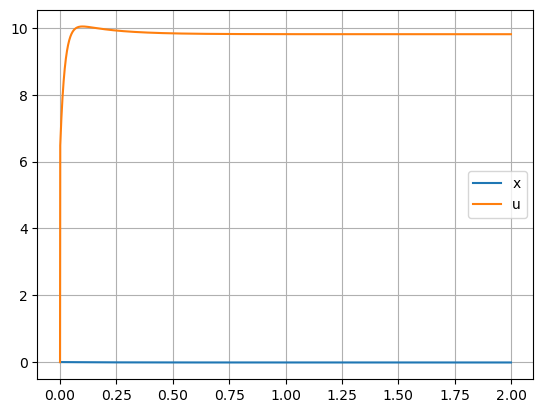

In [4]:
plt.plot(t, x[0,:], t, ul)
plt.legend(['x','u'])
plt.grid(True)